In [1]:
import QuantLib as ql
import math
import numpy as np

In [127]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate

class bond_price_cal_:

    def __init__(self, t, all_equity_num, issue_date, first_coupon_date, first_dividend_date, face_value, S_0, r, q, credit_risk, T, N, D, delta, maturity_prem, call_provision, if_soft_call, if_soft_put, method, put_provision, put_start_date, coupon_rate, X, conversation_start_date, path_num):
        """
        issue_date, first_dividend_date, face_value, S_0, r, q, T, N, 
        D 分红, 
        delta, 
        maturity_prem 如果持有到期末的premium, 
        call_provision, if_soft_call, if_soft_put, method, put_provision, put_start_year, 
        coupon_rate, 
        X 执行价, 
        no_con_time 没有赎回的days, no_call_time 没有回售的days, 
        path_num monte carlo模拟的path数
        """
        calendar = ql.China()
        day_count = ql.Actual365Fixed()
        end_of_month = True
        self.t = t
        self.all_equity_num = all_equity_num
        self.issue_date = issue_date
        self.maturity_date = calendar.advance(
            issue_date, ql.Period(int(T), ql.Days))
        self.first_dividend_date = first_dividend_date
        self.first_coupon_date = first_coupon_date
        self.face_value = face_value
        self.S_0 = S_0
        self.T = T
        self.occured_time = day_count.yearFraction(issue_date, t)
        #print(self.occured_time, day_count.dayCount(issue_date, t))
        self.delta_t = day_count.yearFraction(self.t, self.maturity_date)/N
        self.r = r
        self.q = q
        self.credit_risk = credit_risk
        self.N = N
        self.D = D
        self.u = math.exp(math.sqrt((delta**2-credit_risk)*self.delta_t))
        self.d = 1/self.u
        #print(self.u,self.d)
        self.delta = delta
        self.maturity_prem = maturity_prem
        self.mu = r-q-delta**2/2
        self.if_soft_call = if_soft_call
        self.if_soft_put = if_soft_put
        self.method = method
        self.Mc = call_provision
        self.Mp = put_provision
        self.X = X
        self.a = math.exp((r-q)*self.delta_t)
        self.recovery = 40
        self.put_start_date = put_start_date
        self.conversation_start_date = conversation_start_date
        self.coupon_rate = coupon_rate
        self.path_num = path_num      
        print('---------------------basic information-----------------')
        print('dt:', self.delta_t)
        print('the bond start at %s, end at %s'%(self.issue_date,self.maturity_date))
        print('the dividend is %.2f'%(self.D))
        print('the volatility of stock:', self.delta)
        print('the risk-free rate', self.r)
        print('coupon_rate:', self.coupon_rate)
        print('maturity Premium:', self.maturity_prem)
        if all_equity_num == 0:
            print('no dilution mode')
        else:
            print('dilution applied')
        self.pu = (self.a-self.d*math.exp(-credit_risk*self.delta_t)) / \
            (self.u-self.d)
        self.pd = (self.u*math.exp(-credit_risk*self.delta_t)-self.a) / \
            (self.u-self.d)
        self.p_default = 1-math.exp(-credit_risk*self.delta_t)
        print(self.pu,self.pd,self.p_default)
#         print('put provision start at %s th year'%(self.put_start_year))
#         fig, ax = plt.subplots(figsize=(12, 10))
#         ax.set_title('S0 = %.2f, r = %.2f, sigma = %.2f, simulation number = %.f ' %(self.S_0,self.r,self.delta,self.path_num), fontsize=12)
        # create list of daily returns using random normal distribution
        self.price_list_all = []
        for i in range(self.path_num):
            daily_returns = np.random.normal(
                (self.mu/self.T), self.delta/math.sqrt(self.T), self.T)+1
            # set starting price and create price series generated by above random daily returns
            price_list = [self.S_0]
            for x in daily_returns:
                price_list.append(price_list[-1]*x)
            self.price_list_all.append(price_list)
            # Generate Plots - price series and histogram of daily returns
#             ax.plot(price_list)
#         plt.show()
    
    def gen_call_bar(self):
        if self.if_soft_call == True:
            if self.method == 'Bloomberg':
                count = 0
                for path_id in range(self.path_num):
                    for t in range(30, self.T):
                        temp = self.price_list_all[path_id][t-30:t]
                        k = len([i for i in temp if i > 1.3*self.X])
                        if k >= 15:
                            count += 1
                            break
                prob = count/self.path_num
                max_path = pd.Series([max(path)
                                      for path in self.price_list_all])
                Hbar = max_path.quantile([1-prob]).values
                print('Hbar:', Hbar)
                return Hbar*(self.face_value/self.X)
        else:
            return self.Mc

    def gen_put_bar(self):
        if self.if_soft_put == True:
            count = 0
            for path_id in range(self.path_num):
                for t in range(30, self.T):
                    temp = self.price_list_all[path_id][t-30:t]
                    k = len([i for i in temp if i < 0.7*self.X])
                    if k >= 30:
                        count += 1
                        break
            prob = count/self.path_num
            min_path = pd.Series([min(path) for path in self.price_list_all])
            Hbar = min_path.quantile([prob]).values
            print('Hbar:', Hbar)
            return Hbar*(self.face_value/self.X)
        else:
            return self.Mp

    def cal_vest_period(self):
        calendar = ql.China()
        day_count = ql.Actual365Fixed()
        if self.t < self.conversation_start_date:
            no_con_yf = day_count.yearFraction(
                self.t, self.conversation_start_date)
        else:
            no_con_yf = 0
        x_n = math.floor(no_con_yf/self.delta_t)
        
        if self.t < self.put_start_date:
            no_put_yf = day_count.yearFraction(self.t,self.put_start_date)
        else:
            no_put_yf = 0
        y_n = math.floor(no_put_yf/self.delta_t)
        return x_n, y_n

    def coupon_cal(self):
        calendar = ql.China()
        day_count = ql.Actual365Fixed()
        coupon_date = [calendar.advance(self.first_coupon_date, ql.Period(
            i, ql.Years)) for i in range(1, int(self.T/252)+1)]
        # print(coupon_date)
        coupon_yf_list = []
        for d in coupon_date:
            if self.t < d and d <= self.maturity_date:
                yf = day_count.yearFraction(self.t, d)
                coupon_yf_list.append(yf)
        # print(coupon_yf_list)
        node_approx = [int(np.floor(yf/self.delta_t)) for yf in coupon_yf_list]
        #print('pay dividend at these nodes:',node_approx)
        return node_approx

#         coupon_payment = [cr * self.face_value for cr in self.coupon_rate]
#         print(coupon_payment)
#         return coupon_payment

    def dividend_cal(self):
        calendar = ql.China()
        fixedPaymentConvention = ql.ModifiedFollowing
        bussiness_convention = ql.Unadjusted
        day_count = ql.Actual365Fixed()
        end_of_month = True
        dividend_date = [calendar.advance(self.first_dividend_date, ql.Period(
            i, ql.Years)) for i in range(0, int(self.T/252))]
        # print(dividend_date)
        dividend_yf_list = []
        for d in dividend_date:
            if self.t < d and d <= self.maturity_date:
                yf = day_count.yearFraction(self.t, d)
            # if d <= self.maturity_date:
                dividend_yf_list.append(yf)
        # print(dividend_yf_list)
        node_approx = [int(np.floor(yf/self.delta_t))
                       for yf in dividend_yf_list]
        #print('pay dividend at these nodes:',node_approx)
        return len(node_approx), node_approx
    

    def check_remain_share(self,dt):
        share_check_date = [calendar.advance(conversation_start_date,ql.Period(3*i,ql.Months)) for i in range(0,10)]
        remain_share = [3e6,2.999e6,2.998e6,2.998e6,2.998e6,2.998e6,2.998e6,2.998e6,2.997e6,2.994e6]
        share_check_yf = [day_count.yearFraction(conversation_start_date,d) for d in share_check_date]
        f = interpolate.interp1d(share_check_yf, remain_share, kind="slinear")
        try:  
            return 3e6- f(dt)
        except:
            return (3e6-2.994e6)+dt*3*1e5
    
    def exchangable_bond(self):
        calendar = ql.China()
        day_count = ql.Actual365Fixed()
        Mc = self.gen_call_bar()
        print('the call boundary is %.2f' % (Mc))
        Mp = self.gen_put_bar()
        print('the put boundary is %.2f' % (Mp))
        x_n, y_n = self.cal_vest_period()
        print('There is no conversation before %.f node and no put provision before %.f node ' % (
            x_n, y_n))
        node_approx_coupon = self.coupon_cal()
        print('pay coupon at these nodes:', node_approx_coupon)
        dividend_times, node_approx_dividend = self.dividend_cal()
        print('pay dividend at these nodes:', node_approx_dividend)
        V = np.zeros((self.N+1, self.N+1))
        Q = np.zeros((self.N+1, self.N+1))
        coupon_NPV = [cr * self.face_value for cr in self.coupon_rate]
        print('paid %.2f at maturity:' % (coupon_NPV[-1]))
        self.X -= dividend_times * self.D
        for j in range(self.N+1):
            V[j, self.N] = max(self.S_0*(self.u**(2*j-self.N)),
                               0) - dividend_times * self.D
            Q[j, self.N] = max((self.face_value + coupon_NPV[-1])*self.maturity_prem,
                               (self.face_value/self.X) * V[j, self.N])
        for n in range(self.N-1, -1, -1):
            temp_coupon = 0
            temp_dividend = 0
            print('back loop to %d node' % (n))

            if n >= y_n and n >= x_n:
                print('put provision start, conversation permitted')
                if n in node_approx_coupon:
                    temp_coupon = coupon_NPV[int(
                        self.occured_time + self.delta_t * n)-1]
                    print('%.2f coupon paied at %.2f year ' %
                          (temp_coupon, self.delta_t * n))
                if n in node_approx_dividend:
                    temp_dividend = self.D
                    self.X += temp_dividend
                    print('%.2f dividend occured at %.2f year, the conversation ratio changed to %.4f ' % (
                        temp_dividend, self.delta_t * n, self.face_value/self.X))
                if self.all_equity_num == 0:
                    dilution_factor = 1 
                else:
                    time_to_con = day_count.yearFraction(self.conversation_start_date,calendar.advance(self.t,ql.Period(int(self.delta_t * n*252),ql.Days)))
                    dilution_factor = self.all_equity_num/(self.all_equity_num + self.check_remain_share(time_to_con) * self.face_value/self.X)
                    print('%.2f shares already be converted, dilution factor is %.2f'%(self.check_remain_share(time_to_con),dilution_factor))
                for k in range(n+1):
                    V[k, n] = math.exp(-self.r*self.delta_t) * \
                        (self.pu*V[k+1, n+1]+self.pd * V[k, n+1]) + temp_dividend
                    rollback = math.exp(-self.r*self.delta_t)*(
                        self.pu * Q[k+1, n+1]+self.pd*Q[k, n+1]+self.p_default*self.recovery) + temp_coupon
                    Q[k, n] = max(min(rollback, Mc), Mp,
                                  (self.face_value/self.X)*V[k, n]*dilution_factor)

            if n < x_n and n < y_n:
                print('no conversation and no put provision')
                if n in node_approx_coupon:
                    temp_coupon = coupon_NPV[int(
                        self.occured_time + self.delta_t * n)-1]
                    print('%.2f coupon paied at %.2f year ' %
                          (temp_coupon, self.delta_t * n))
                if n in node_approx_dividend:
                    temp_dividend = self.D
                    self.X += temp_dividend
                    print('%.2f dividend occured at %.2f year, the conversation ratio changed to %.4f ' % (
                        temp_dividend, self.delta_t * n, self.face_value/self.X))
                for k in range(n+1):
                    V[k, n] = math.exp(-self.r*self.delta_t) * \
                        (self.pu*V[k+1, n+1]+self.pd * V[k, n+1]) + temp_dividend
                    rollback = math.exp(-self.r*self.delta_t)*(
                        self.pu * Q[k+1, n+1]+self.pd*Q[k, n+1]+self.p_default*self.recovery) + temp_coupon
                    Q[k, n] = min(rollback, Mc)
                    
            if n < x_n and n >= y_n:
                print('no conversation but has put provision')
                if n in node_approx_coupon:
                    temp_coupon = coupon_NPV[int(
                        self.occured_time + self.delta_t * n)-1]
                    print('%.2f coupon paied at %.2f year ' %
                          (temp_coupon, self.delta_t * n))
                if n in node_approx_dividend:
                    temp_dividend = self.D
                    self.X += temp_dividend
                    print('%.2f dividend occured at %.2f year, the conversation ratio changed to %.4f ' % (
                        temp_dividend, self.delta_t * n, self.face_value/self.X))
                for k in range(n+1):
                    V[k, n] = math.exp(-self.r*self.delta_t) * \
                        (self.pu*V[k+1, n+1]+self.pd * V[k, n+1]) + temp_dividend
                    rollback = math.exp(-self.r*self.delta_t)*(
                        self.pu * Q[k+1, n+1]+self.pd*Q[k, n+1]+self.p_default*self.recovery) + temp_coupon
                    Q[k, n] = max(min(rollback, Mc), Mp)   
                    
            if n >= x_n and n < y_n:
                print('conversation permitted but no put provision')
                if self.all_equity_num == 0:
                    dilution_factor = 1 
                else:
                    time_to_con = day_count.yearFraction(self.conversation_start_date,calendar.advance(self.t,ql.Period(int(self.delta_t * n*252),ql.Days)))
                    dilution_factor = self.all_equity_num/(self.all_equity_num +self.check_remain_share(time_to_con) * self.face_value/self.X)
                print('dilution factor is %.2f'%(dilution_factor))
                if n in node_approx_coupon:
                    temp_coupon = coupon_NPV[int(
                        self.occured_time + self.delta_t * n)-1]
                    print('%.2f coupon paied at %.2f year ' %
                          (temp_coupon, self.delta_t * n))
                if n in node_approx_dividend:
                    temp_dividend = self.D
                    self.X += temp_dividend
                    print('%.2f dividend occured at %.2f year, the conversation ratio changed to %.4f ' % (
                        temp_dividend, self.delta_t * n, self.face_value/self.X))
                for k in range(n+1):
                    V[k, n] = math.exp(-self.r*self.delta_t) * \
                        (self.pu*V[k+1, n+1]+self.pd * V[k, n+1]) + temp_dividend
                    rollback = math.exp(-self.r*self.delta_t)*(
                        self.pu * Q[k+1, n+1]+self.pd*Q[k, n+1]+self.p_default*self.recovery) + temp_coupon
                    Q[k, n] = max(min(rollback, Mc),(self.face_value/self.X)*V[k, n]*dilution_factor)

        print('The price of exchangeable bond is ' + str(round(Q[0, 0], 4)))
        return Q[0, 0]

In [130]:
test1 = bond_price_cal_(ql.Date(24,6,2019),2.86e8,ql.Date(24,6,2019),ql.Date(24,6,2019),ql.Date(13,7,2020), 100, 18, 0.05, 0.0018, 0.01, 252*6, 30, 0.03, 
                        0.5358, 1.15, 130, True, True,'Bloomberg', 95, ql.Date(24,6,2023), [0.005, 0.007, 0.01, 0.015, 0.018, 0.030], 
                        18.01, ql.Date(30,12,2019), 1000)

---------------------basic information-----------------
dt: 0.19899543378995432
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.5358
the risk-free rate 0.05
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
dilution applied
0.4652157520180047 0.5327962722905398 0.001987975691455701


In [131]:
test1.exchangable_bond()

Hbar: [24.36987447]
the call boundary is 135.31
Hbar: [11.65412781]
the put boundary is 64.71
There is no conversation before 2 node and no put provision before 20 node 
pay coupon at these nodes: [5, 10, 15, 20, 25]
pay dividend at these nodes: [5, 10, 15, 20, 25]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
1574219.18 shares already be converted, dilution factor is 0.97
back loop to 28 node
put provision start, conversation permitted
1516684.93 shares already be converted, dilution factor is 0.97
back loop to 27 node
put provision start, conversation permitted
1457506.85 shares already be converted, dilution factor is 0.97
back loop to 26 node
put provision start, conversation permitted
1399972.60 shares already be converted, dilution factor is 0.97
back loop to 25 node
put provision start, conversation permitted
1.50 coupon paied at 4.97 year 
0.03 dividend occured at 4.97 year, the conversation ratio changed to 5.5897 
1342438.36 shares al

121.98977940061539

In [136]:
stock_data = pd.read_csv('/Users/wangchenghang/Desktop/nus_semester_2/QF5202/002907.SZ_1.csv')
adjclose = list(stock_data['Open'])[-30:]
date_cal = stock_data['Date']
calendar = ql.China()
Date_list = [calendar.advance(ql.Date(22,2,2022),ql.Period(i,ql.Days)) for i in range(0,28)]

In [133]:
price_list_1 = []
price_list_2 = []
for i in range(0,28):
    stock_price = adjclose[i]
    calc_date = Date_list[i]
    print(calc_date)
    print(stock_price)
    test1 = bond_price_cal_(calc_date,0,ql.Date(24,6,2019),ql.Date(24,6,2019),ql.Date(13,7,2020), 100, stock_price, 0.044, 0.0018, 0.01, 252*6, 30, 0.03, 
                        0.5358, 1.15, 130, True, True,'Bloomberg', 95, ql.Date(24,6,2023), [0.005, 0.007, 0.01, 0.015, 0.018, 0.030], 
                        18.01, ql.Date(30,12,2019), 500)
    test2 = bond_price_cal_(calc_date,2.86e8,ql.Date(24,6,2019),ql.Date(24,6,2019),ql.Date(13,7,2020), 100, stock_price, 0.044, 0.0018, 0.01, 252*6, 30, 0.03, 
                        0.5358, 1.15, 130, True, True,'Bloomberg', 95, ql.Date(24,6,2023), [0.005, 0.007, 0.01, 0.015, 0.018, 0.030], 
                        18.01, ql.Date(30,12,2019), 500)
    bond_price_1 = test1.exchangable_bond()
    bond_price_2 = test2.exchangable_bond()
    price_list_1.append(bond_price_1)
    price_list_2.append(bond_price_2)

February 22nd, 2022
13.82
---------------------basic information-----------------
dt: 0.11004566210045662
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.5358
the risk-free rate 0.044
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
no dilution mode
0.47234804891588694 0.5265520997434472 0.001099851340665814
---------------------basic information-----------------
dt: 0.11004566210045662
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.5358
the risk-free rate 0.044
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
dilution applied
0.47234804891588694 0.5265520997434472 0.001099851340665814
Hbar: [24.67628127]
the call boundary is 137.01
Hbar: [11.72130397]
the put boundary is 65.08
There is no conversation before 0 node and no put provision before 12 node 
pay coupon at these nodes: [3, 12, 21]
pay dividend at these nod

Hbar: [24.07392229]
the call boundary is 133.67
Hbar: [11.68573899]
the put boundary is 64.88
There is no conversation before 0 node and no put provision before 12 node 
pay coupon at these nodes: [3, 12, 21]
pay dividend at these nodes: [3, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
1.50 coupon paied at 2.31 year 
0.03 dividend occured at 2.31 year, the conversation ratio changed to 5.5710 
back loop to 20 node
put provisi

Hbar: [24.43017514]
the call boundary is 135.65
Hbar: [11.76506636]
the put boundary is 65.33
There is no conversation before 0 node and no put provision before 12 node 
pay coupon at these nodes: [2, 12, 21]
pay dividend at these nodes: [3, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
1578328.77 shares already be converted, dilution factor is 0.97
back loop to 28 node
put provision start, conversation permitted
1547917.81 shares already be converted, dilution factor is 0.97
back loop to 27 node
put provision start, conversation permitted
1515041.10 shares already be converted, dilution factor is 0.97
back loop to 26 node
put provision start, conversation permitted
1481342.47 shares already be converted, dilution factor is 0.97
back loop to 25 node
put provision start, conversation permitted
1450931.51 shares already be converted, dilution factor is 0.97
back loop to 24 node
put provision start, conversation permitted
1418054.79 shares

---------------------basic information-----------------
dt: 0.10949771689497717
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.5358
the risk-free rate 0.044
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
dilution applied
0.47241782748920524 0.5264877946105965 0.0010943779001979514
Hbar: [24.36639135]
the call boundary is 135.29
Hbar: [11.66331119]
the put boundary is 64.76
There is no conversation before 0 node and no put provision before 12 node 
pay coupon at these nodes: [2, 12, 21]
pay dividend at these nodes: [3, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provis

Hbar: [24.46149843]
the call boundary is 135.82
Hbar: [11.67410021]
the put boundary is 64.82
There is no conversation before 0 node and no put provision before 12 node 
pay coupon at these nodes: [2, 12, 21]
pay dividend at these nodes: [3, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
1578328.77 shares already be converted, dilution factor is 0.97
back loop to 28 node
put provision start, conversation permitted
1545452.05 shares already be converted, dilution factor is 0.97
back loop to 27 node
put provision start, conversation permitted
1515041.10 shares already be converted, dilution factor is 0.97
back loop to 26 node
put provision start, conversation permitted
1481342.47 shares already be converted, dilution factor is 0.97
back loop to 25 node
put provision start, conversation permitted
1450931.51 shares already be converted, dilution factor is 0.97
back loop to 24 node
put provision start, conversation permitted
1418054.79 shares

---------------------basic information-----------------
dt: 0.10922374429223744
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.5358
the risk-free rate 0.044
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
dilution applied
0.47245278113434336 0.5264555776969396 0.0010916411687172944
Hbar: [25.00555813]
the call boundary is 138.84
Hbar: [11.66526355]
the put boundary is 64.77
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 12, 21]
pay dividend at these nodes: [3, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provis

Hbar: [24.53536821]
the call boundary is 136.23
Hbar: [11.64614091]
the put boundary is 64.66
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 12, 21]
pay dividend at these nodes: [3, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
1579150.68 shares already be converted, dilution factor is 0.97
back loop to 28 node
put provision start, conversation permitted
1548739.73 shares already be converted, dilution factor is 0.97
back loop to 27 node
put provision start, conversation permitted
1515863.01 shares already be converted, dilution factor is 0.97
back loop to 26 node
put provision start, conversation permitted
1484630.14 shares already be converted, dilution factor is 0.97
back loop to 25 node
put provision start, conversation permitted
1451753.42 shares already be converted, dilution factor is 0.97
back loop to 24 node
put provision start, conversation permitted
1421342.47 shares

---------------------basic information-----------------
dt: 0.10876712328767123
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.5358
the risk-free rate 0.044
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
dilution applied
0.47251113311010895 0.5264017869569706 0.001087079932920676
Hbar: [24.21806825]
the call boundary is 134.47
Hbar: [11.72703142]
the put boundary is 65.11
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 11, 21]
pay dividend at these nodes: [3, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provisi

Hbar: [24.35516472]
the call boundary is 135.23
Hbar: [11.64975742]
the put boundary is 64.68
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 11, 21]
pay dividend at these nodes: [3, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
1579150.68 shares already be converted, dilution factor is 0.97
back loop to 28 node
put provision start, conversation permitted
1547917.81 shares already be converted, dilution factor is 0.97
back loop to 27 node
put provision start, conversation permitted
1515863.01 shares already be converted, dilution factor is 0.97
back loop to 26 node
put provision start, conversation permitted
1484630.14 shares already be converted, dilution factor is 0.97
back loop to 25 node
put provision start, conversation permitted
1451753.42 shares already be converted, dilution factor is 0.97
back loop to 24 node
put provision start, conversation permitted
1421342.47 shares

---------------------basic information-----------------
dt: 0.10849315068493151
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.5358
the risk-free rate 0.044
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
dilution applied
0.472546202099692 0.5263694547188625 0.0010843431814455684
Hbar: [24.36146163]
the call boundary is 135.27
Hbar: [11.50052935]
the put boundary is 63.86
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 11, 21]
pay dividend at these nodes: [3, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provisio

Hbar: [24.27431762]
the call boundary is 134.78
Hbar: [11.6631207]
the put boundary is 64.76
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 11, 21]
pay dividend at these nodes: [3, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
1578328.77 shares already be converted, dilution factor is 0.97
back loop to 28 node
put provision start, conversation permitted
1547917.81 shares already be converted, dilution factor is 0.97
back loop to 27 node
put provision start, conversation permitted
1515863.01 shares already be converted, dilution factor is 0.97
back loop to 26 node
put provision start, conversation permitted
1484630.14 shares already be converted, dilution factor is 0.97
back loop to 25 node
put provision start, conversation permitted
1451753.42 shares already be converted, dilution factor is 0.97
back loop to 24 node
put provision start, conversation permitted
1421342.47 shares 

---------------------basic information-----------------
dt: 0.1080365296803653
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.5358
the risk-free rate 0.044
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
dilution applied
0.4726047472798556 0.5263154708078195 0.0010797819123247177
Hbar: [24.2890741]
the call boundary is 134.86
Hbar: [11.60006185]
the put boundary is 64.41
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 11, 21]
pay dividend at these nodes: [3, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provision

Hbar: [24.07760693]
the call boundary is 133.69
Hbar: [11.6082663]
the put boundary is 64.45
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 11, 21]
pay dividend at these nodes: [2, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
1579150.68 shares already be converted, dilution factor is 0.97
back loop to 28 node
put provision start, conversation permitted
1548739.73 shares already be converted, dilution factor is 0.97
back loop to 27 node
put provision start, conversation permitted
1516684.93 shares already be converted, dilution factor is 0.97
back loop to 26 node
put provision start, conversation permitted
1485452.05 shares already be converted, dilution factor is 0.97
back loop to 25 node
put provision start, conversation permitted
1453397.26 shares already be converted, dilution factor is 0.97
back loop to 24 node
put provision start, conversation permitted
1422164.38 shares 

---------------------basic information-----------------
dt: 0.10757990867579909
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.5358
the risk-free rate 0.044
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
dilution applied
0.4726634142014692 0.5262613651761545 0.001075220622376194
Hbar: [24.44478695]
the call boundary is 135.73
Hbar: [11.6707626]
the put boundary is 64.80
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 11, 21]
pay dividend at these nodes: [2, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provision

Hbar: [24.35692227]
the call boundary is 135.24
Hbar: [11.62405287]
the put boundary is 64.54
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 11, 21]
pay dividend at these nodes: [2, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
1579150.68 shares already be converted, dilution factor is 0.97
back loop to 28 node
put provision start, conversation permitted
1548739.73 shares already be converted, dilution factor is 0.97
back loop to 27 node
put provision start, conversation permitted
1516684.93 shares already be converted, dilution factor is 0.97
back loop to 26 node
put provision start, conversation permitted
1485452.05 shares already be converted, dilution factor is 0.97
back loop to 25 node
put provision start, conversation permitted
1453397.26 shares already be converted, dilution factor is 0.97
back loop to 24 node
put provision start, conversation permitted
1422986.30 shares

---------------------basic information-----------------
dt: 0.10730593607305935
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.5358
the risk-free rate 0.044
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
dilution applied
0.4726986731104029 0.5262288430511872 0.0010724838384097435
Hbar: [24.52884442]
the call boundary is 136.20
Hbar: [11.63347222]
the put boundary is 64.59
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 11, 21]
pay dividend at these nodes: [2, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provisi

Hbar: [24.31212044]
the call boundary is 134.99
Hbar: [11.64551604]
the put boundary is 64.66
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 11, 21]
pay dividend at these nodes: [2, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
1579972.60 shares already be converted, dilution factor is 0.97
back loop to 28 node
put provision start, conversation permitted
1549561.64 shares already be converted, dilution factor is 0.97
back loop to 27 node
put provision start, conversation permitted
1519150.68 shares already be converted, dilution factor is 0.97
back loop to 26 node
put provision start, conversation permitted
1486273.97 shares already be converted, dilution factor is 0.97
back loop to 25 node
put provision start, conversation permitted
1455863.01 shares already be converted, dilution factor is 0.97
back loop to 24 node
put provision start, conversation permitted
1423808.22 shares

---------------------basic information-----------------
dt: 0.10684931506849314
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.5358
the risk-free rate 0.044
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
dilution applied
0.4727575364237939 0.5261745410610693 0.0010679225151365435
Hbar: [24.45533234]
the call boundary is 135.79
Hbar: [11.63820531]
the put boundary is 64.62
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 11, 20]
pay dividend at these nodes: [2, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
back loop to 24 node
put provisi

Hbar: [24.43734952]
the call boundary is 135.69
Hbar: [11.6240814]
the put boundary is 64.54
There is no conversation before 0 node and no put provision before 11 node 
pay coupon at these nodes: [2, 11, 20]
pay dividend at these nodes: [2, 12, 21]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
1579972.60 shares already be converted, dilution factor is 0.97
back loop to 28 node
put provision start, conversation permitted
1549561.64 shares already be converted, dilution factor is 0.97
back loop to 27 node
put provision start, conversation permitted
1519150.68 shares already be converted, dilution factor is 0.97
back loop to 26 node
put provision start, conversation permitted
1486273.97 shares already be converted, dilution factor is 0.97
back loop to 25 node
put provision start, conversation permitted
1455863.01 shares already be converted, dilution factor is 0.97
back loop to 24 node
put provision start, conversation permitted
1423808.22 shares 

In [134]:
ori_ex_price = [115.6, 116.4, 116.5, 117.2, 116.9, 117.1, 119, 119.1, 117.8, 115.3, 111.9, 111.7, 120, 115,
    114.4, 112.7, 112.7, 115.3, 115.7, 117, 115.4, 124.8, 145.9, 131, 116, 119, 117.9, 117.8]

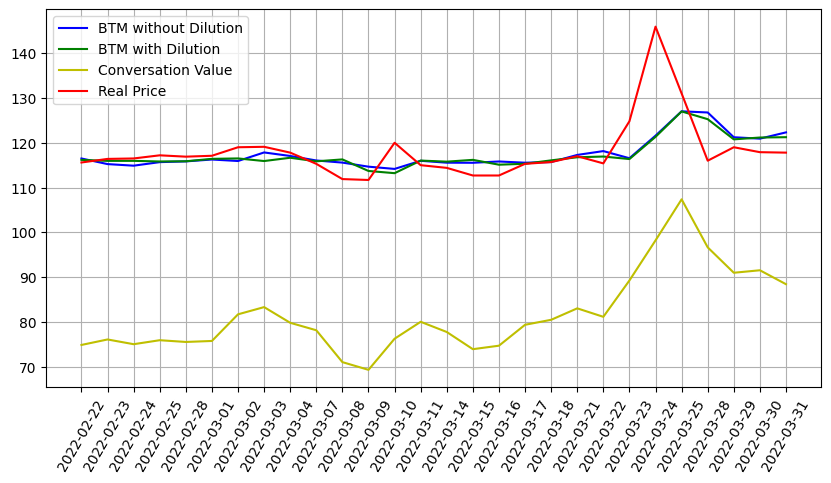

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(111)
date_xtick = ['2022-02-22','2022-02-23', '2022-02-24','2022-02-25','2022-02-28','2022-03-01', '2022-03-02', '2022-03-03',
              '2022-03-04', '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10', '2022-03-11',
              '2022-03-14', '2022-03-15','2022-03-16', '2022-03-17', '2022-03-18', '2022-03-21', '2022-03-22', '2022-03-23',
              '2022-03-24', '2022-03-25',  '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31']
adjclose_conv = [a*100/18.01 for a in list(stock_data['Adj Close'])[-30:-2]]
plt.xticks(rotation=60)
ax.plot(date_xtick, price_list_1, color='b',label = 'BTM without Dilution')
ax.plot(date_xtick, price_list_2, color='g',label = 'BTM with Dilution')
ax.plot(date_xtick,adjclose_conv, color='y',label = 'Conversation Value')
ax.plot(date_xtick,ori_ex_price, color='r',label = 'Real Price')
plt.legend()
plt.grid()
plt.show()

---------------------basic information-----------------
dt: 0.19899543378995432
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.00
the volatility of stock: 0.5
the risk-free rate 0.05
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
no dilution mode
the call boundary is 130.00
the put boundary is 95.00
There is no conversation before 2 node and no put provision before 20 node 
pay coupon at these nodes: [5, 10, 15, 20, 25]
pay dividend at these nodes: [5, 10, 15, 20, 25]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
1.50 coupon paied at 4.97 year 
0.00 dividend occured at 4.97 year, the conversation ratio changed to 6.6667 
back loop 

conversation permitted but no put provision
dilution factor is 1.00
back loop to 8 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 7 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 6 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 5 node
conversation permitted but no put provision
dilution factor is 1.00
3.00 coupon paied at 0.99 year 
0.00 dividend occured at 0.99 year, the conversation ratio changed to 5.0000 
back loop to 4 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 3 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 2 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 1 node
no conversation and no put provision
back loop to 0 node
no conversation and no put provision
The price of exchangeable bond is 120.9108
---------------------basic information-----------

back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
1.50 coupon paied at 4.97 year 
0.05 dividend occured at 4.97 year, the conversation ratio changed to 4.0323 
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision start, conversation permitted
1.00 coupon paied at 3.98 year 
0.05 dividend occured at 3.98 year, the conversation ratio changed to 4.0241 
back loop to 19 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 18 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 17 node
conversation permitted but no put provision
dilution factor i

back loop to 13 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 12 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 11 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 10 node
conversation permitted but no put provision
dilution factor is 1.00
0.50 coupon paied at 1.99 year 
0.00 dividend occured at 1.99 year, the conversation ratio changed to 3.3333 
back loop to 9 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 8 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 7 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 6 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 5 node
conversation permitted but no put provision
dilution factor is 1.00
3.00 coupon paied at 0.99 year 
0.00 dividend occured at 0.99 year, the conversation ratio cha

back loop to 8 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 7 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 6 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 5 node
conversation permitted but no put provision
dilution factor is 1.00
3.00 coupon paied at 0.99 year 
0.00 dividend occured at 0.99 year, the conversation ratio changed to 2.5000 
back loop to 4 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 3 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 2 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 1 node
no conversation and no put provision
back loop to 0 node
no conversation and no put provision
The price of exchangeable bond is 120.9108
---------------------basic information-----------------
dt: 0.19899543378995432
the bond start at June 24th, 2019, en

put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
1.50 coupon paied at 4.97 year 
0.05 dividend occured at 4.97 year, the conversation ratio changed to 2.0080 
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision start, conversation permitted
1.00 coupon paied at 3.98 year 
0.05 dividend occured at 3.98 year, the conversation ratio changed to 2.0060 
back loop to 19 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 18 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 17 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 16 node
conversation permitted but no put provision
dilution facto

back loop to 20 node
put provision start, conversation permitted
1.00 coupon paied at 3.98 year 
0.00 dividend occured at 3.98 year, the conversation ratio changed to 1.6667 
back loop to 19 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 18 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 17 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 16 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 15 node
conversation permitted but no put provision
dilution factor is 1.00
0.70 coupon paied at 2.98 year 
0.00 dividend occured at 2.98 year, the conversation ratio changed to 1.6667 
back loop to 14 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 13 node
conversation permitted but no put provision
dilution factor is 1.00
back loop to 12 node
conversation permitted but no put provision
dilution factor is 1.00
bac

<Figure size 576x432 with 0 Axes>

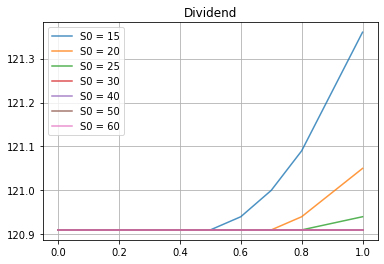

In [121]:
plt.figure(figsize=(8, 6))
fig, ax = plt.subplots()
ax.set_title('Dividend')
for S0 in [15,20,25,30,40,50,60]:
    price = []
    for D in [0,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1]:
        test1 = bond_price_cal_(ql.Date(24,6,2019),0,ql.Date(24,6,2019),ql.Date(24,6,2019),ql.Date(13,7,2020), 100, S0, 0.05, 0, 0.01, 252*6, 30, D, 
                            0.5, 1.15, 130, False, False,'Bloomberg', 95, ql.Date(24,6,2023),  [0.005, 0.007, 0.01, 0.015, 0.018, 0.030], S0, ql.Date(30,12,2019), 0)
        price.append(round(test1.exchangable_bond(),2))
    ax.plot([0,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1],price,label = 'S0 = %s'%(S0),alpha = 0.8)
ax.ticklabel_format(style='plain')
plt.legend()
plt.grid()
plt.show()

---------------------basic information-----------------
dt: 0.19899543378995432
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.5
the risk-free rate 0.05
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
no dilution mode
the call boundary is 130.00
the put boundary is 95.00
There is no conversation before 1 node and no put provision before 20 node 
pay coupon at these nodes: [5, 10, 15, 20, 25]
pay dividend at these nodes: [5, 10, 15, 20, 25]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
1.50 coupon paied at 4.97 year 
0.03 dividend occured at 4.97 year, the conversation ratio changed to 2.0048 
back loop 

maturity Premium: 1.15
no dilution mode
the call boundary is 130.00
the put boundary is 95.00
There is no conversation before 7 node and no put provision before 20 node 
pay coupon at these nodes: [5, 10, 15, 20, 25]
pay dividend at these nodes: [5, 10, 15, 20, 25]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
1.50 coupon paied at 4.97 year 
0.03 dividend occured at 4.97 year, the conversation ratio changed to 2.0048 
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 

<Figure size 432x288 with 0 Axes>

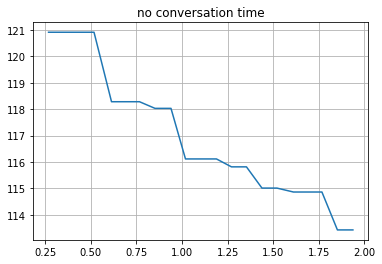

In [123]:
calendar = ql.China()
day_count = ql.Actual365Fixed()
plt.figure(figsize=(6, 4))
price = []
fig, ax = plt.subplots()
ax.set_title('no conversation time')
no_con_list = [calendar.advance(ql.Date(30,6,2019),ql.Period(i,ql.Months)) for i in range(3,24)]
no_con_yf = [day_count.yearFraction(ql.Date(24,6,2019),d) for d in no_con_list]
for d in no_con_list:
    test1 = bond_price_cal_(ql.Date(24,6,2019),0,ql.Date(24,6,2019),ql.Date(24,6,2019),ql.Date(13,7,2020), 100, 50, 0.05, 0, 0.01, 252*6, 30, 0.03, 
                            0.5, 1.15, 130, False, False,'Bloomberg', 95, ql.Date(24,6,2023),  [0.005, 0.007, 0.01, 0.015, 0.018, 0.030], 50, d, 0)
    price.append(test1.exchangable_bond())
ax.plot(no_con_yf,price)
ax.ticklabel_format(style='plain')
plt.grid()
plt.show()

---------------------basic information-----------------
dt: 0.19899543378995432
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.2
the risk-free rate 0.05
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
no dilution mode
---------------------basic information-----------------
dt: 0.19899543378995432
the bond start at June 24th, 2019, end at June 11th, 2025
the dividend is 0.03
the volatility of stock: 0.2
the risk-free rate 0.05
coupon_rate: [0.005, 0.007, 0.01, 0.015, 0.018, 0.03]
maturity Premium: 1.15
no dilution mode
the call boundary is 130.00
the put boundary is 95.00
There is no conversation before 2 node and no put provision before 20 node 
pay coupon at these nodes: [5, 10, 15, 20, 25]
pay dividend at these nodes: [5, 10, 15, 20, 25]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop

Hbar: [66.61800723]
the call boundary is 133.24
the put boundary is 95.00
There is no conversation before 2 node and no put provision before 20 node 
pay coupon at these nodes: [5, 10, 15, 20, 25]
pay dividend at these nodes: [5, 10, 15, 20, 25]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
1.50 coupon paied at 4.97 year 
0.03 dividend occured at 4.97 year, the conversation ratio changed to 2.0048 
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision s

the call boundary is 130.00
the put boundary is 95.00
There is no conversation before 2 node and no put provision before 20 node 
pay coupon at these nodes: [5, 10, 15, 20, 25]
pay dividend at these nodes: [5, 10, 15, 20, 25]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
1.50 coupon paied at 4.97 year 
0.03 dividend occured at 4.97 year, the conversation ratio changed to 2.0048 
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision start, conversation p

Hbar: [68.21229829]
the call boundary is 136.42
the put boundary is 95.00
There is no conversation before 2 node and no put provision before 20 node 
pay coupon at these nodes: [5, 10, 15, 20, 25]
pay dividend at these nodes: [5, 10, 15, 20, 25]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
1.50 coupon paied at 4.97 year 
0.03 dividend occured at 4.97 year, the conversation ratio changed to 2.0048 
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision s

the call boundary is 130.00
the put boundary is 95.00
There is no conversation before 2 node and no put provision before 20 node 
pay coupon at these nodes: [5, 10, 15, 20, 25]
pay dividend at these nodes: [5, 10, 15, 20, 25]
paid 3.00 at maturity:
back loop to 29 node
put provision start, conversation permitted
back loop to 28 node
put provision start, conversation permitted
back loop to 27 node
put provision start, conversation permitted
back loop to 26 node
put provision start, conversation permitted
back loop to 25 node
put provision start, conversation permitted
1.50 coupon paied at 4.97 year 
0.03 dividend occured at 4.97 year, the conversation ratio changed to 2.0048 
back loop to 24 node
put provision start, conversation permitted
back loop to 23 node
put provision start, conversation permitted
back loop to 22 node
put provision start, conversation permitted
back loop to 21 node
put provision start, conversation permitted
back loop to 20 node
put provision start, conversation p

<Figure size 432x288 with 0 Axes>

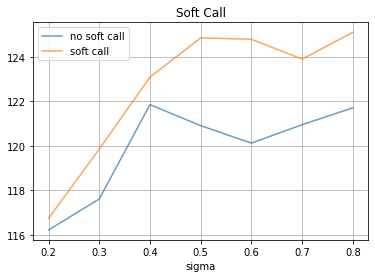

In [126]:
plt.figure(figsize=(6, 4))
price1 = []
price2 = []
fig, ax = plt.subplots()
ax.set_title('Soft Call')
for sigma in [0.2,0.3,0.4,0.5,0.6,0.7,0.8]:
    test1 = bond_price_cal_(ql.Date(24,6,2019),0,ql.Date(24,6,2019),ql.Date(24,6,2019),ql.Date(13,7,2020), 100, 50, 0.05, 0, 0.01, 252*6, 30, 0.03, 
                            sigma, 1.15, 130, False, False,'Bloomberg', 95, ql.Date(24,6,2023),  [0.005, 0.007, 0.01, 0.015, 0.018, 0.030], 50,ql.Date(30,12,2019) , 0)

    test2 = bond_price_cal_(ql.Date(24,6,2019),0,ql.Date(24,6,2019),ql.Date(24,6,2019),ql.Date(13,7,2020), 100, 50, 0.05, 0, 0.01, 252*6, 30, 0.03, 
                            sigma, 1.15, 130, True, False,'Bloomberg', 95, ql.Date(24,6,2023),  [0.005, 0.007, 0.01, 0.015, 0.018, 0.030], 50, ql.Date(30,12,2019), 1000)
    price1.append(test1.exchangable_bond())
    price2.append(test2.exchangable_bond())
ax.plot([0.2,0.3,0.4,0.5,0.6,0.7,0.8],price1,label = 'no soft call',alpha = 0.7)
ax.plot([0.2,0.3,0.4,0.5,0.6,0.7,0.8],price2,label = 'soft call',alpha = 0.7)
ax.ticklabel_format(style='plain')
plt.legend()
plt.xlabel('sigma')
plt.grid()
plt.show()